# Transformation Solver for Relative Sequential Transformations

*E.B. "Xoleras" de Cruz*

### Problem Statement
Define a transformation tree to be a tree $G$ where each vertex holds rotation and translation data $R$ and $T$ of an axis in space, and the final orientation of said axis is the sequence of rotations and transformations of its parent vertices up to the root.

For example, given a transformation tree $G$, there is a path from the root to any vertex ($N_0$ to $N_i$). The axis represented by $N_i$ has a rotation of $R_0 R_1 R_2 ... R_{i-1}$ where each $R$ is a rotation matrix, and a translation of $v_0 + R_0 v_1 + R_1 v_2 + ... + R_{i-1} v_i$

Now let's establish the following:

$R^*_i := R_0 R_1 ... R_i$


$T^*_i := v_0 + R_0 v_1 + R_1 v_2 + ... + R_{i-1} v_i$

Then we can solve the following problem:

Given a tranformation tree $G$ and a vertex $g$, determine the final rotation matrix $R^*$ and translation $T^*$ of $g$

Furthermore, we can solve the following intermediate problem:

Given an axis with a particular rotation and translation, and a vertex $g$ of $G$, find the orientation $<\hat{R}, \hat{T}>$ so that if the axis were to be a child vertex of $g$, then it would remain in its original place. In other words its original orientation $<R, T>$ would be the same as its orientation within the tree structure $<R^*, T^*>$
That is, $<R, T> \, = \, <R^* \hat{R}, T^* + \hat{T}>$

### Solutions

For rotation:


$\hat{R} = (R^*)^{-1}R$

For translation:

$T^*$ is some rotated vector $R^* \vec{v}$ and there is a vector $\vec{x}$ that will yield the original translation $T$, that is $R^*(\vec{v} + \vec{x}) = T$, therefore


$T^* + R^* \vec{x} = T$

$R^* \vec{x} = T - T^*$

Which is a linear system and we know it has a single nonzero solution because the axes are linearly independent and we assume the tree structure is nontrivial; that is, it concerns nodes with non-identity translations.


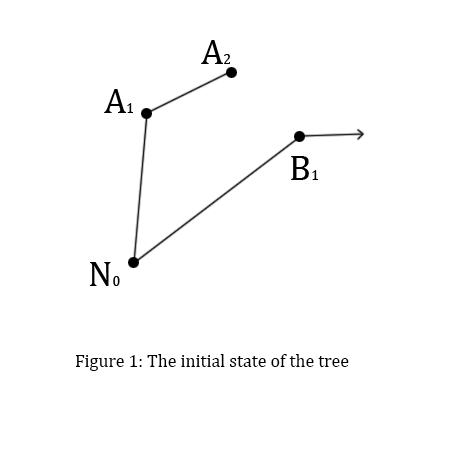

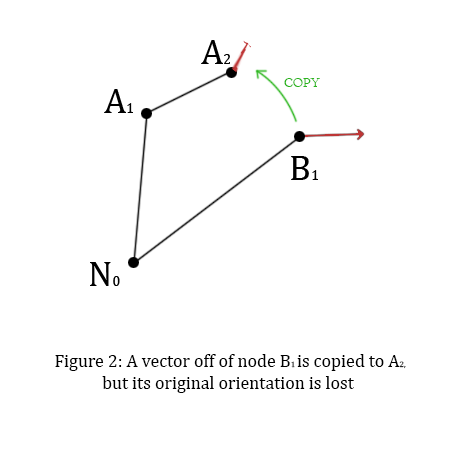

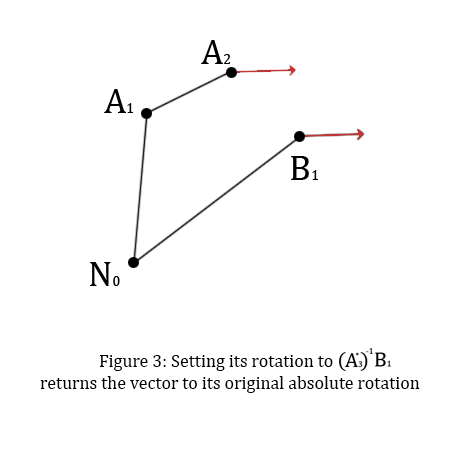

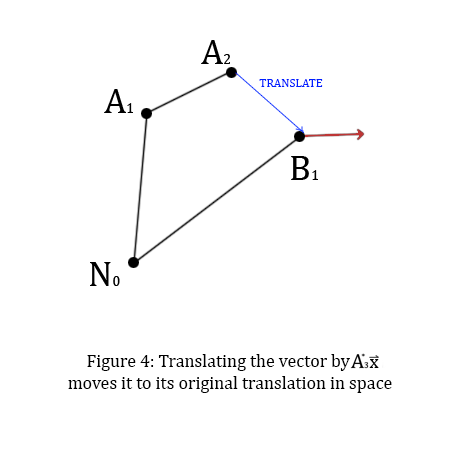



### Practical Application

In the Gamebryo Engine and other game engines, skeletal structures exist to represent an organization of space of individual elements relative to each other, as well as skeletons for animation. The tools to determine correct orientation of individual objects whose orientation is latent (such as collision objects) are either non-existent, primitive or proprietary. Users cannot simply decide that a collision mesh will have a certain orientation, because that is not an object with an explicit axis. The parent node of the collision object decides the final absolute orientation --here nodes are vertices in the transformation tree, but with more data.

### Implementation

Given these solutions, the respective algorithms would normally be to simply apply and/or solve the equations and return the result. However, Gamebryo's relative rotations are expressed in terms of Euler angles, so the final solution for the user is to express the rotations in terms of Euler angles, and the input problem should also be thought of in terms of Euler angles. Of course, we merely have to convert to and from Euler angles to rotation matrices as a wrapper around the original algorithm.



In [ ]:
import numpy as np
from numpy import linalg as LA
from math import sin, cos, atan2, asin

In [ ]:
# in gamebryo, Y is pitch, P is roll, R is yaw
PI = 3.1415926536

def vec(arr):
  return np.matrix([arr]).T

def rad(d):
  return round(d*PI/180, 6)

def deg(r):
  return round(r*180/PI, 6)

def r2d(arr):
  return [deg(r) for r in arr]

def apply_all(mats):
  r_mat = np.identity(3)

  for mat in mats:
    r_mat = r_mat@mat

  return r_mat

def rotate(roll, pitch, yaw, v):
  R_x = np.stack([[1, 0, 0], [0, cos(roll), -sin(roll)], [0, sin(roll), cos(roll)]])
  R_y = np.stack([[cos(pitch), 0, sin(pitch)], [0, 1, 0], [-sin(pitch), 0, cos(pitch)]])
  R_z = np.stack([[cos(yaw), -sin(yaw), 0], [sin(yaw), cos(yaw), 0], [0, 0, 1]])

  return (((R_z@R_y)@R_x)@v).round(decimals=6)

def translate(x, y, z, v):
  M_t = np.identity(4)
  M_t[0][3] = x
  M_t[1][3] = y
  M_t[2][3] = z

  v4 = np.vstack([v, [1]])
  v4 = M_t@v4
  return np.delete(v4, 3, 0)

def lhc_vec(v):
  return vec([-v[1, 0], v[0, 0], v[2, 0]])

def e2m(x, y, z, m):
	sinX = sin( x )
	cosX = cos( x )
	sinY = sin( y )
	cosY = cos( y )
	sinZ = sin( z )
	cosZ = cos( z )

	m[0, 0] = cosY * cosZ
	m[0, 1] = -cosY * sinZ
	m[0, 2] = sinY
	m[1, 0] = sinX * sinY * cosZ + sinZ * cosX
	m[1, 1] = cosX * cosZ - sinX * sinY * sinZ
	m[1, 2] = -sinX * cosY
	m[2, 0] = sinX * sinZ - cosX * sinY * cosZ
	m[2, 1] = cosX * sinY * sinZ + sinX * cosZ
	m[2, 2] = cosX * cosY

def m2e(m, a):
  if m[0, 2] < 1.0:
    if m[0, 2] > -1.0:
      a[0] = atan2( -m[1, 2], m[2, 2] )
      a[1] = asin( m[0, 2] )
      a[2] = atan2( -m[0, 1], m[0, 0] )
      return True

    a[0] = -atan2( -m[1, 0], m[1, 1] )
    a[1] = -PI / 2
    a[2] = 0.0
    return False

  a[0] = atan2( m[1, 0], m[1, 1])
  a[1] = PI / 2
  a[2] = 0.0
  return False

# apply a series of transformations to an axis
# here rotations are euler angles
def transform(rotations, translations):
  assert(len(rotations) == len(translations) - 1)

  r = np.identity(3)
  v = translations[0]

  for i in range(len(rotations)):
    r_i = np.zeros((3, 3))
    e2m(rad(rotations[i][0]), rad(rotations[i][1]), rad(rotations[i][2]), r_i)
    r = r@r_i
    v = v + r@translations[i + 1]

  return r, v

# here they are rotation matrices
def transform_pm(rotations, translations):
  assert(len(rotations) == len(translations) - 1)

  r = np.identity(3)
  v = translations[0]

  for i in range(len(rotations)):
    r = r@rotations[i]
    v = v + r@translations[i + 1]

  return r, v

In [ ]:
# This is a demo similar to the figures displayed above

r0 = np.zeros((3, 3))
v0 = vec([0, 0, 0])

e2m(rad(45), 0, 0, r0)

v1 = vec([0, 128, 0])
v1 = r0@v1
v1

print(v1)

r1 = np.zeros((3, 3))
e2m(0, 0, rad(45), r1)
r2 = r0@r1

v2 = vec([128, 0, 0])
v2 = r2@v2 + v1
v2

print(v2)

np.linalg.solve(r2, v0 - v2)

[[ 0.        ]
 [90.50968278]
 [90.5096532 ]]
[[ 90.50968278]
 [154.50968278]
 [154.50963229]]


matrix([[-218.5096532 ],
        [ -90.50968278],
        [   0.        ]])

In [ ]:
# This is a basic demonstration of the input arguments for a transform call
rot = [[45, 0, 0], [0, 0, 45]]
tra = [vec([0, 0, 0]), vec([0, 128, 0]), vec([128, 0, 0])]
R, T = transform(rot, tra)

matrix([[-218.5096532 ],
        [ -90.50968278],
        [   0.        ]])

In [ ]:
# This solves rotation individually, with the output being the angles to set the node
r_hat = np.zeros((3, 3))
e2m(0, 0, rad(51), r_hat)
m_T = (LA.inv(r2)@r_hat)
angles = [0, 0, 0]
m2e(m_T, angles)
r2d(angles)

[-35.264385, 29.999989, 15.735619]

In [ ]:
# Here is built a transformation tree with one path
v0 = vec([957, 136, -14])

buf = np.zeros((3, 3))
e2m(0, 0, rad(-9.94), buf)
node_spine = [buf]
node_spine_t = [v0] + [vec([79, 0, 0])]

buf = np.zeros((3, 3))
e2m(0, 0, rad(-14.61), buf)
node_spine1 = node_spine + [buf]
node_spine1_t = node_spine_t + [vec([106, 0, 0])]

buf = np.zeros((3, 3))
e2m(0, 0, rad(-0.8), buf)
node_spine2 = node_spine1 + [buf]
node_spine2_t = node_spine1_t + [vec([106, 0, 0])]

buf = np.zeros((3, 3))
e2m(0, 0, rad(13.32), buf)
node_spine3 = node_spine2 + [buf]
node_spine3_t = node_spine2_t + [vec([106, 0, 0])]

buf = np.zeros((3, 3))
e2m(0, 0, rad(26.59), buf)
node_neck = node_spine3 + [buf]
node_neck_t = node_spine3_t + [vec([180, 0, 0])]

buf = np.zeros((3, 3))
e2m(rad(68.96), rad(60.68), rad(114.32), buf)
node_lclavicle = node_neck + [buf]
node_lclavicle_t = node_neck_t + [vec([0, 0, 75])]

# Build the final orientation of a node in the tree
R, T = transform_pm(node_lclavicle, node_lclavicle_t)

# r_desired is the desired final absolute rotation of a child axis
# t_desired is the desired final absolute translation of a child axis
r_desired = np.identity(3)
t_desired = vec([0, 0, 0])

[29.415473, 78.356221, 163.175175]

In [ ]:
# solve rotation
m_T = (LA.inv(R)@r_desired)
angles = [0, 0, 0]
m2e(m_T, angles)
r2d(angles)

In [ ]:
# solve translation
np.linalg.solve(R, t_desired - T)

matrix([[  307.71913108],
        [  366.68324685],
        [-1502.92423454]])